# 权重衰退、正则化

### 库函数

In [11]:
import matplotlib.pyplot as plt
from IPython import display

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 设置 SVG 显示
        plt.rcParams['figure.figsize'] = figsize
        plt.rcParams['svg.fonttype'] = 'none'  # 使 SVG 中的文本可编辑
        
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]
        else:
            self.axes = self.axes.flatten()
        
        # 配置坐标轴
        self.config_axes = lambda ax: self._set_axes(
            ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        
        self.X, self.Y, self.fmts = None, None, fmts
        self.legend = legend

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴属性"""
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        if legend:
            ax.legend(legend)
        ax.grid(True)

    def add(self, x, y):
        """向图表中添加多个数据点"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        
        # 初始化数据存储
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]
        
        # 添加数据点
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        # 清除并重新绘制
        self.axes[0].cla()
        for i, (x_data, y_data, fmt) in enumerate(zip(self.X, self.Y, self.fmts)):
            if x_data and y_data:  # 确保有数据可绘制
                self.axes[0].plot(x_data, y_data, fmt)
        
        # 配置坐标轴
        self.config_axes(self.axes[0])
        
        # 显示图形
        display.display(self.fig)
        display.clear_output(wait=True)

    def close(self):
        """关闭图形"""
        plt.close(self.fig)

def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 求导数不影响乘除法，这里除是因为要用平均损失
            param.grad.zero_()

def linreg(X, w, b):
    return torch.matmul(X, w) + b

def square_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 生成数据

In [4]:
import torch
from torch import nn
from torch.utils import data

In [5]:
# 构造一个人造数据集
def synthetic_data(w, b, example_num):
    """生成 y=Xw+b 噪声"""
    X = torch.normal(0, 1, (example_num, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1)) # -1自动计算，1代表列向量

def load_array(load_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*load_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [6]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size)

### 初始化模型参数

In [17]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义$L_{2}$范数惩罚

In [12]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

def evaluate_loss(net, ite, loss):
    sum_l = 0
    for X, y in ite:
        sum_l += loss(net(X), y)
    return sum_l.sum() / len(ite)

### 训练

In [13]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X : linreg(X, w, b), square_loss
    num_epochs, lr = 100, 0.03
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)

        with torch.no_grad():
            if (epoch + 1) % 5 == 0:
                animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                         evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 忽略正则化直接训练

w的L2范数是： 11.92851448059082


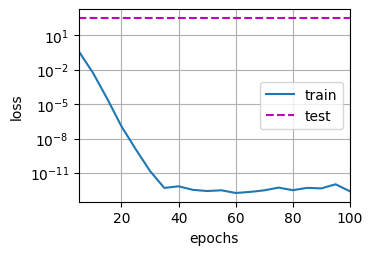

In [18]:
train(lambd=0)

### 使用权重衰减

w的L2范数是： 0.03139272332191467


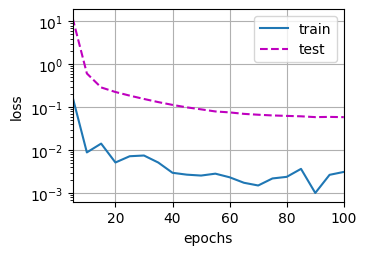

In [19]:
train(lambd=3)

w的L2范数是： 0.030331900343298912


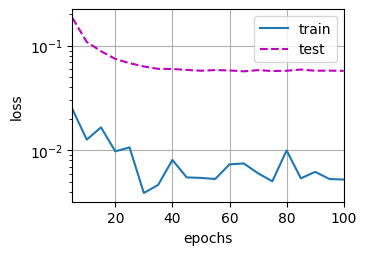

In [21]:
train(lambd=7)

# 简洁实现

In [29]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {'params': net[0].weight, "weight_decay": wd}, # 第一组参数：权重，应用权重衰减
        {"params": net[0].bias} # 第二组参数：偏置，不使用权重衰减
    ], lr=lr)
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                        xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        with torch.no_grad():
            if (epoch + 1) % 5 == 0:
                animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                         evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', net[0].weight.norm().item())

### 不设置权重衰减/正则化

w的L2范数是： 12.266042709350586


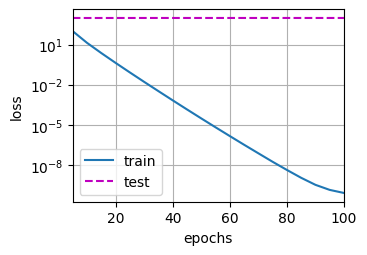

In [30]:
train_concise(0)

### 设置正则化

w的L2范数是： 0.11754079908132553


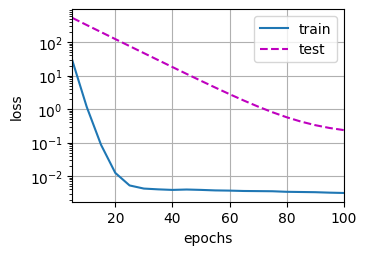

In [31]:
train_concise(4)